In [42]:
%matplotlib inline
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

sns.set(style="darkgrid")

PATH = '/home/st/Documents/Uni/Masterarbeit/Data/2024-02-29_rows.json'

rows = json.load(open(PATH, 'r'))
rows_df = pd.DataFrame(rows)
question_rows = []
all_annotations = []

for row in rows:
    for question in row['questions']:
        new_row = row.copy()
        annotations = [annotation for annotation in question['annotations'] if
                       not annotation['skipped'] and not annotation['archived']]
        new_row['question'] = question['question']

        for index, annotation in enumerate(annotations):
            all_annotations.append(annotation)
            new_row[f'answers{index}'] = annotation['answerLines']
            new_row[f'noAnswer{index}'] = annotation['noAnswer']
            new_row[f'user{index}'] = annotation['user']

        question_rows.append(new_row)

questions_df = pd.DataFrame(question_rows,
                            columns=['question', 'answers0', 'answers1', 'noAnswer0', 'noAnswer1', 'context', 'city',
                                     'language'])
annotations_df = pd.DataFrame(all_annotations)
tmp = annotations_df.copy()
annotations_df['selected'] = tmp.apply(lambda x: len(x.answerLines), axis=1)
annotations_df

,answerLines,poor,noAnswer,skipped,comment,user,created,archived,selected
0,[2],False,False,False,,81adb4c5-22c1-4ae1-8497-f746e8041cd0,2024-02-20T12:40:45.868Z,False,1
1,[],False,True,False,,2ef98f87-20d3-41d9-8c2d-19ec20a69dd2,2024-02-13T20:59:49.873Z,False,0
2,"[3, 4, 5, 6, 7]",False,False,False,,ffb094e8-796a-4cc9-8b65-e6bb8dd5ebc5,2024-02-17T20:07:39.347Z,False,5
3,[1],False,False,False,,edf15548-b98f-48d0-b315-cc17bf18a0e5,2024-02-18T11:51:55.770Z,False,1
4,"[18, 20]",False,False,False,,f3fef4a9-eaf8-46cb-b630-117c2428b06e,2024-02-21T09:11:47.999Z,False,2
...,...,...,...,...,...,...,...,...,...
2435,[10],False,False,False,,edf15548-b98f-48d0-b315-cc17bf18a0e5,2024-02-28T15:50:12.610Z,False,1
2436,"[2, 3, 4, 5, 6, 7, 8]",False,False,False,,8e071a73-9338-4311-a85c-55843f7b2f3b,2024-02-09T12:47:13.250Z,False,7
2437,"[2, 3, 4, 5, 6, 7, 8]",False,False,False,,000b5917-4875-4fac-b7df-139d9db1c100,2024-02-14T14:54:35.019Z,False,7
2438,"[12, 6, 7]",False,False,False,,10e2728b-de41-41b7-9902-97a5348ceced,2024-02-20T13:20:39.643Z,False,3


In [18]:
# Annotations stats
def print_annotations_stats(df, name):
    annotation_0 = df.count().answers0
    annotation_1 = df.count().answers1
    print(f'### {name} ###')
    print(
        f'Total annotations: {annotation_0 + annotation_1} (single: {annotation_0 - annotation_1} | double: {annotation_1})')
    print('')


print_annotations_stats(questions_df, 'Total')
print_annotations_stats(questions_df[questions_df['language'] == 'de'], 'German')
print_annotations_stats(questions_df[questions_df['language'] == 'en'], 'English')

### Total ###
Total annotations: 2440 (single: 958 | double: 741)

### German ###
Total annotations: 1652 (single: 530 | double: 561)

### English ###
Total annotations: 788 (single: 428 | double: 180)


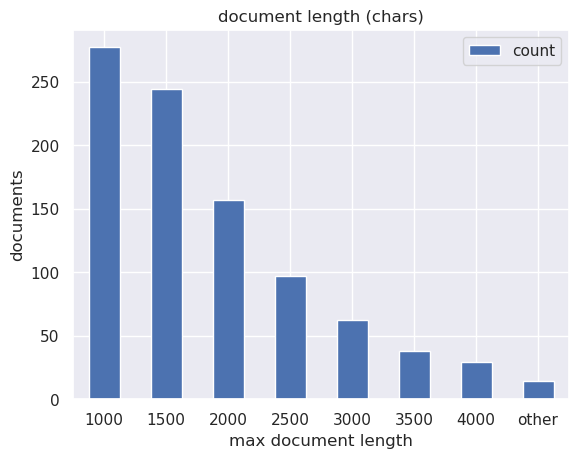

Average context length (chars): 1648.37
Median context length (chars): 1371


In [73]:
# Document stats
documents_df = pd.DataFrame(rows)

group_by_context_length = rows_df.context.str.len().value_counts().reset_index()
group_by_context_length.columns = ['document_length', 'document']
context_length_bins = pd.cut(group_by_context_length['document_length'], bins=numpy.array([0, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 5000]), include_lowest=True).value_counts().reset_index()
context_length_bins.columns = ['bin', 'count']
context_length_bins['sort'] = context_length_bins.bin.map(lambda x: x.left)
context_length_bins = context_length_bins.sort_values('sort')

ax = context_length_bins.plot.bar(rot=0, color='b')
labels = [f'{round(bin.right)}' if bin.right != 5000 else 'other' for bin in context_length_bins['bin']]
ax.set_xticklabels(labels)
plt.title('document length (chars)')
plt.xlabel('max document length')
plt.ylabel('documents')
plt.show()

print(f'Average context length (chars): {round(group_by_context_length.document_length.mean(), 2)}')
print(f'Median context length (chars): {int(group_by_context_length.document_length.median())}')

# tmp = rows_df.copy()
# group_by_answer_count = rows_df.copy()
# group_by_answer_count['answer_count'] = tmp.apply(lambda x: len(x.context.split('\n')) - 1, axis=1)
# group_by_answer_count = group_by_answer_count.answer_count.value_counts().reset_index()
# group_by_answer_count.columns = ['document_length', 'document']
# answer_count_bins = pd.cut(group_by_answer_count['document_length'], bins=numpy.array([0, 5, 10, 15, 20, 25, 30, 35, 40]), include_lowest=True).value_counts().reset_index()
# answer_count_bins.columns = ['bin', 'count']
# answer_count_bins['sort'] = answer_count_bins.bin.map(lambda x: x.left)
# answer_count_bins = answer_count_bins.sort_values('sort')
# 
# ax = answer_count_bins.plot.bar(rot=0, color='b')
# labels = [f'{round(bin.right)}' if bin.right != 40 else 'other' for bin in answer_count_bins['bin']]
# ax.set_yticks(numpy.arange(0, 50, 5))
# ax.set_xticklabels(labels)
# plt.title('document length (sentences)')
# plt.xlabel('max document length')
# plt.ylabel('documents')
# plt.show()
# 
# print(f'Average context length: {round(group_by_answer_count.document_length.mean(), 2)}')
# print(f'Median context length: {int(group_by_answer_count.document_length.median())}')
# 

In [20]:
# Prepare questions with two annotations
tmp = questions_df[~questions_df.answers0.isnull() & ~questions_df.answers1.isnull()]
double_annotations_df = tmp.copy()
double_annotations_df['intersection'] = tmp.apply(lambda x: list(set(x.answers0).intersection(set(x.answers1))), axis=1)
double_annotations_df['diff0'] = tmp.apply(lambda x: list(set(x.answers0).difference(x.answers1)), axis=1)
double_annotations_df['diff1'] = tmp.apply(lambda x: list(set(x.answers1).difference(x.answers0)), axis=1)

max_answers = 4
filtered_double_annotations_df = double_annotations_df[(double_annotations_df.answers0.str.len() <= max_answers) & (double_annotations_df.answers1.str.len() <= max_answers)]

double_annotations_df.head()

,question,answers0,answers1,noAnswer0,noAnswer1,context,city,language,intersection,diff0,diff1
3,Was ist das Motto der Münchner Kammerspiele?,[],"[3, 4, 5, 6, 7]",True,False,Münchner Kammerspiele\nMünchner Kammerspiele\n...,muenchen,de,[],[],"[3, 4, 5, 6, 7]"
13,Wo kann man Informationen zu den Aufnahmeverfa...,"[5, 6]",[6],False,False,Berufsschule\nBerufsschule\nDie berufliche Ers...,muenchen,de,[6],[5],[]
14,Welche Angaben sind in der Gehaltsabrechnung o...,"[10, 11, 12, 13, 14, 15, 16, 4, 5, 6, 7, 8, 9]","[10, 11, 12, 13, 14, 15, 16, 4, 5, 9]",False,False,Gehaltsabrechnung\nGehaltsabrechnung\nWenn Sie...,muenchen,de,"[4, 5, 9, 10, 11, 12, 13, 14, 15, 16]","[6, 7, 8]",[]
15,Was ist meist der Auszahlungsbetrag auf der Ge...,[15],"[1, 14, 15, 16]",False,False,Gehaltsabrechnung\nGehaltsabrechnung\nWenn Sie...,muenchen,de,[15],[],"[16, 1, 14]"
18,Wann stellen Arbeitgeberinnen oder Arbeitgeber...,"[2, 3]","[2, 3]",False,False,Gehaltsabrechnung\nGehaltsabrechnung\nWenn Sie...,muenchen,de,"[2, 3]",[],[]


answers | agreement | one-sided | overlap | no agreement
< 2  | 159 | 35 | 7 | 97
< 3  | 164 | 65 | 17 | 123
< 4  | 168 | 93 | 33 | 141
< 5  | 172 | 107 | 54 | 159
< 7  | 177 | 138 | 74 | 186
< 10 | 178 | 168 | 96 | 207
all  | 179 | 209 | 122 | 231


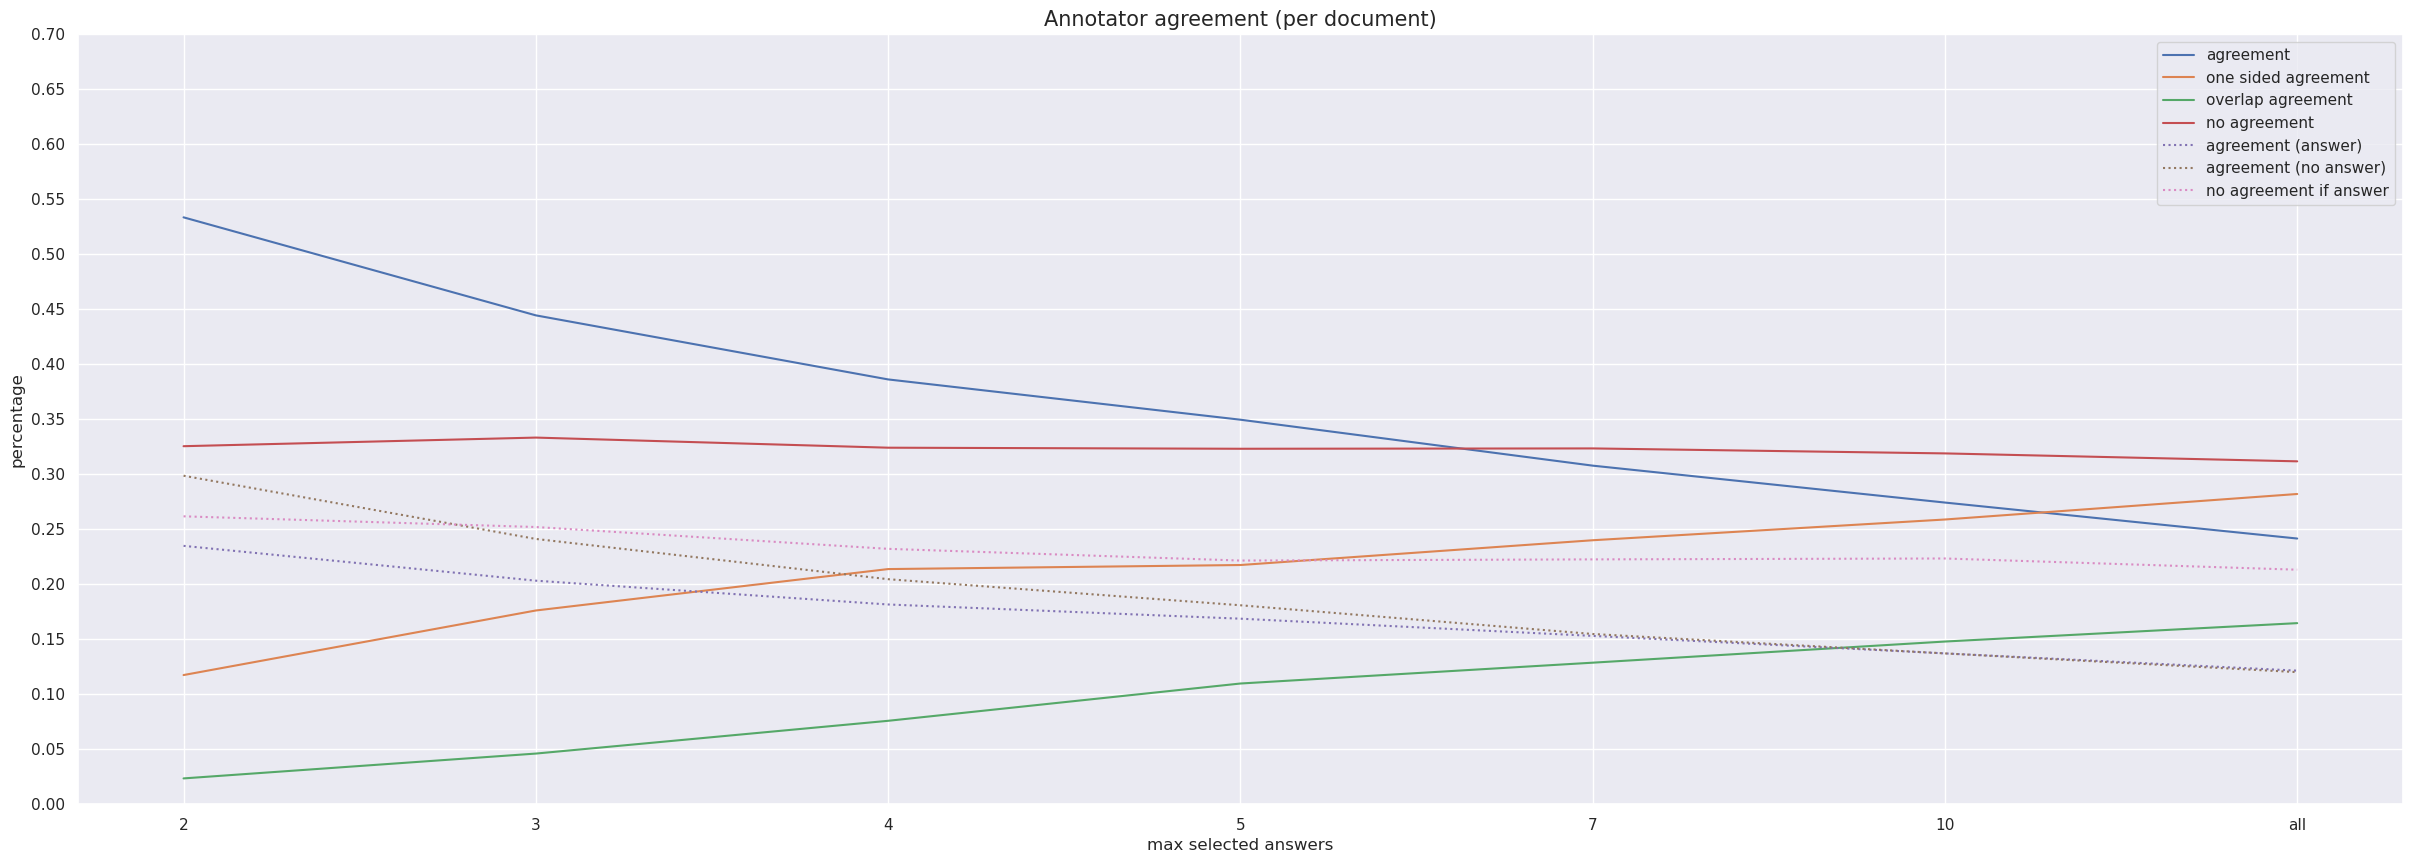

In [75]:
# Plot annotator agreement (per document)
max_answers_thresholds = [2, 3, 4, 5, 7, 10]

def get_annotator_agreement(df, name):
    total_count = len(df)
    raw_agreement = len(df[(df.diff0.str.len() == 0) & (df.diff1.str.len() == 0)])
    agreement = raw_agreement / total_count
    raw_agreement_one_sided = len(df[((df.diff0.str.len() == 0) != (df.diff1.str.len() == 0)) & (df.intersection.str.len() > 0)])
    agreement_one_sided = raw_agreement_one_sided / total_count
    raw_agreement_overlap = len(df[(df.diff0.str.len() > 0) & (df.diff1.str.len() > 0) & (df.intersection.str.len() > 0)])
    agreement_overlap = raw_agreement_overlap / total_count
    raw_no_agreement = len(df[((df.answers0.str.len() > 0) | (df.answers1.str.len() > 0)) & (df.intersection.str.len() == 0)])
    no_agreement = raw_no_agreement / total_count
    print(f'{name} | {raw_agreement} | {raw_agreement_one_sided} | {raw_agreement_overlap} | {raw_no_agreement}')

    agreement_no_answer = len(df[(df.answers0.str.len() == 0) & (df.answers1.str.len() == 0)]) / total_count
    agreement_answer = agreement - agreement_no_answer
    no_agreement_answer = len(df[(df.answers0.str.len() == 0) != (df.answers1.str.len() == 0)]) / total_count

    return [agreement, agreement_one_sided, agreement_overlap, no_agreement, agreement_answer, agreement_no_answer, no_agreement_answer]

def get_double_annotations_max_answers(df, max_answers):
    return df[(df.answers0.str.len() <= max_answers) & (df.answers1.str.len() <= max_answers)]

def get_max_answers_agreement(df):
    agreements = []
    print('answers | agreement | one-sided | overlap | no agreement')
    for max_answers in max_answers_thresholds:
        agreements.append(get_annotator_agreement(get_double_annotations_max_answers(df, max_answers), f'< {max_answers}{"" if len(str(max_answers)) == 2 else " "}'))
    agreements.append(get_annotator_agreement(df, 'all '))
    
    return pd.DataFrame(agreements)

max_answers_agreement_df = get_max_answers_agreement(double_annotations_df)

labels_x = [f'{max_answers}' for max_answers in max_answers_thresholds]
labels_x.append('all')

_,ax = plt.subplots(figsize=(30, 10))
ax.set_title('Annotator agreement (per document)', fontsize=15)
ax.set_xlabel('max selected answers')
ax.set_ylabel('percentage')

for index in range(len(max_answers_agreement_df.columns)):
    max_answers_agreement_df.iloc[:,index].plot.line(ax=ax, linestyle='-' if index < 4 else ':')

ax.legend(['agreement', 'one sided agreement', 'overlap agreement', 'no agreement', 'agreement (answer)', 'agreement (no answer)', 'no agreement if answer']) 
ax.set_xticks(numpy.arange(0, len(max_answers_thresholds) + 1, 1))
ax.set_xticklabels(labels_x)
ax.set_yticks(numpy.arange(0, 0.75, 0.05))
ax.set_ylim(0)
plt.show()# tmp = rows_df.copy()
# group_by_answer_count = rows_df.copy()
# group_by_answer_count['answer_count'] = tmp.apply(lambda x: len(x.context.split('\n')) - 1, axis=1)
# group_by_answer_count = group_by_answer_count.answer_count.value_counts().reset_index()
# group_by_answer_count.columns = ['document_length', 'document']
# answer_count_bins = pd.cut(group_by_answer_count['document_length'], bins=numpy.array([0, 5, 10, 15, 20, 25, 30, 35, 40]), include_lowest=True).value_counts().reset_index()
# answer_count_bins.columns = ['bin', 'count']
# answer_count_bins['sort'] = answer_count_bins.bin.map(lambda x: x.left)
# answer_count_bins = answer_count_bins.sort_values('sort')
# 
# ax = answer_count_bins.plot.bar(rot=0, color='b')
# labels = [f'{round(bin.right)}' if bin.right != 40 else 'other' for bin in answer_count_bins['bin']]
# ax.set_yticks(numpy.arange(0, 50, 5))
# ax.set_xticklabels(labels)
# plt.title('document length (sentences)')
# plt.xlabel('max document length')
# plt.ylabel('documents')
# plt.show()
# 
# print(f'Average context length: {round(group_by_answer_count.document_length.mean(), 2)}')
# print(f'Median context length: {int(group_by_answer_count.document_length.median())}')
# 


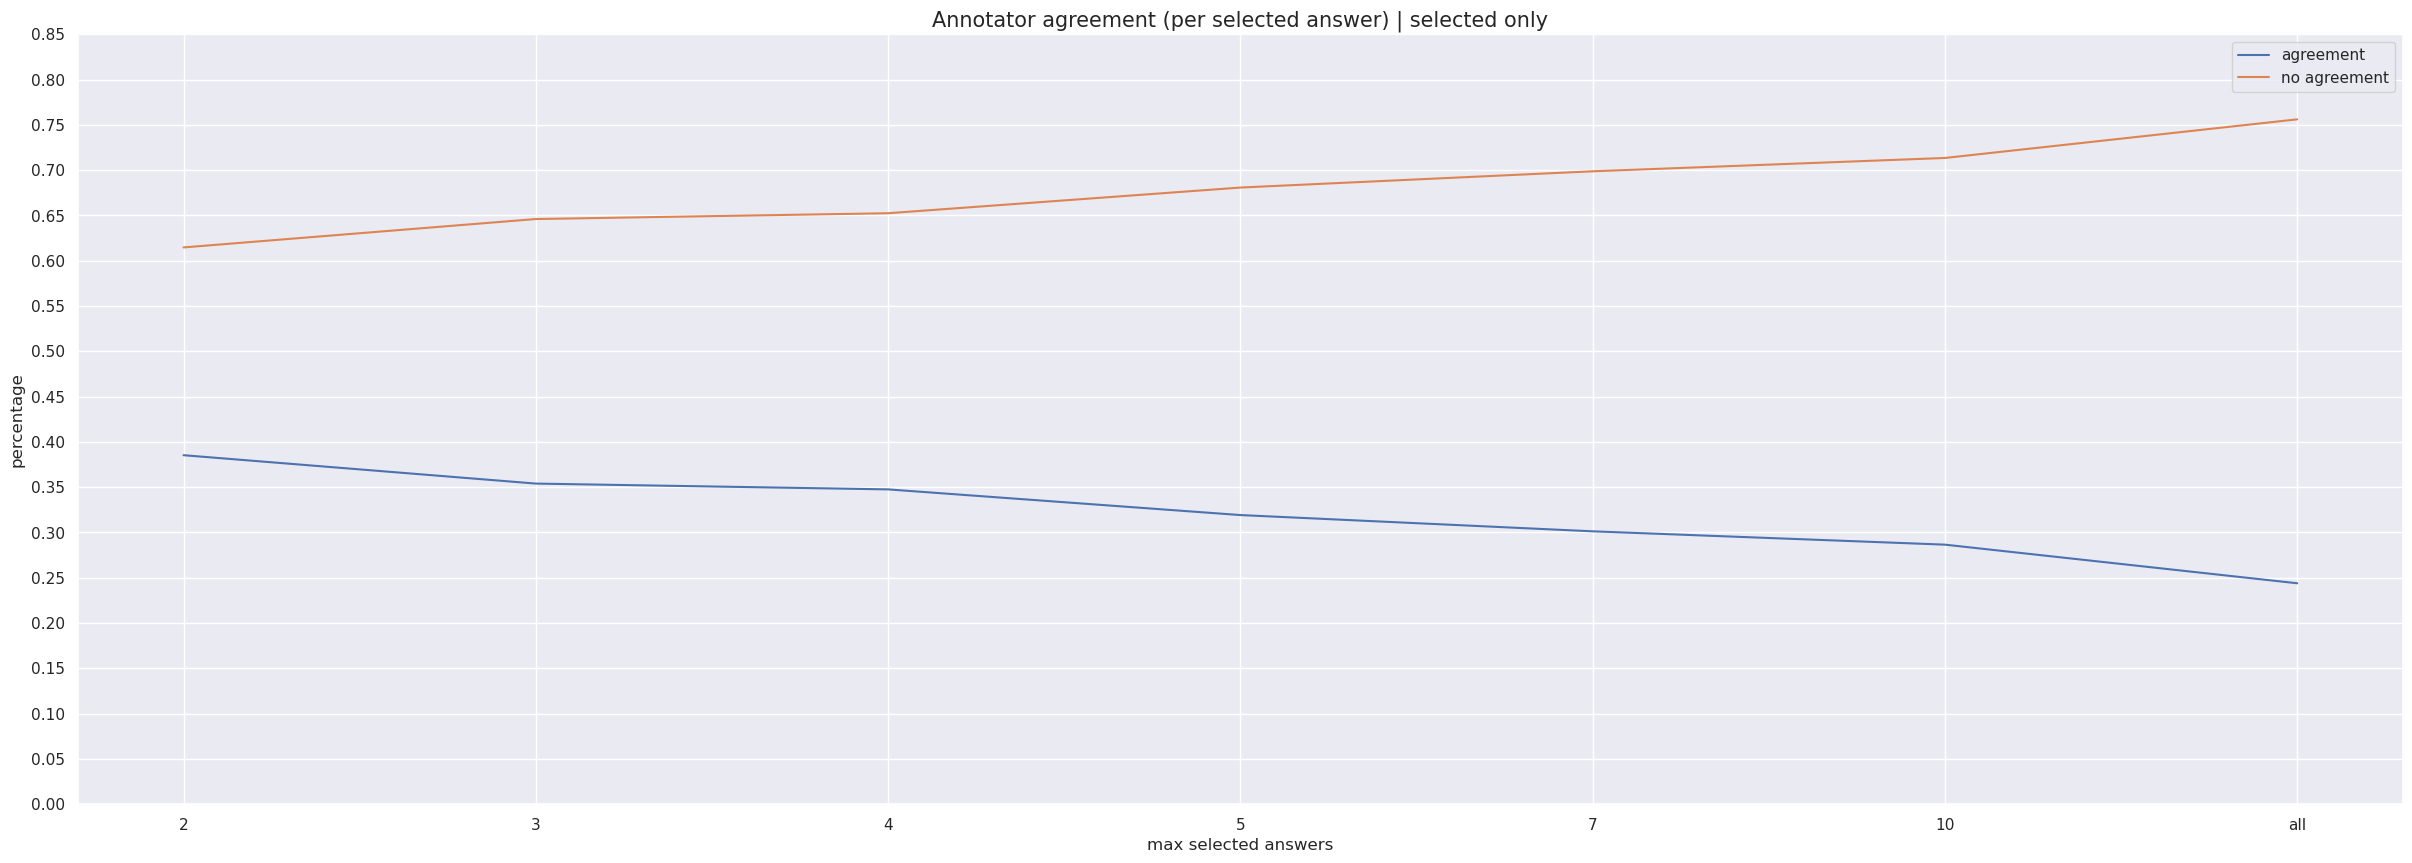

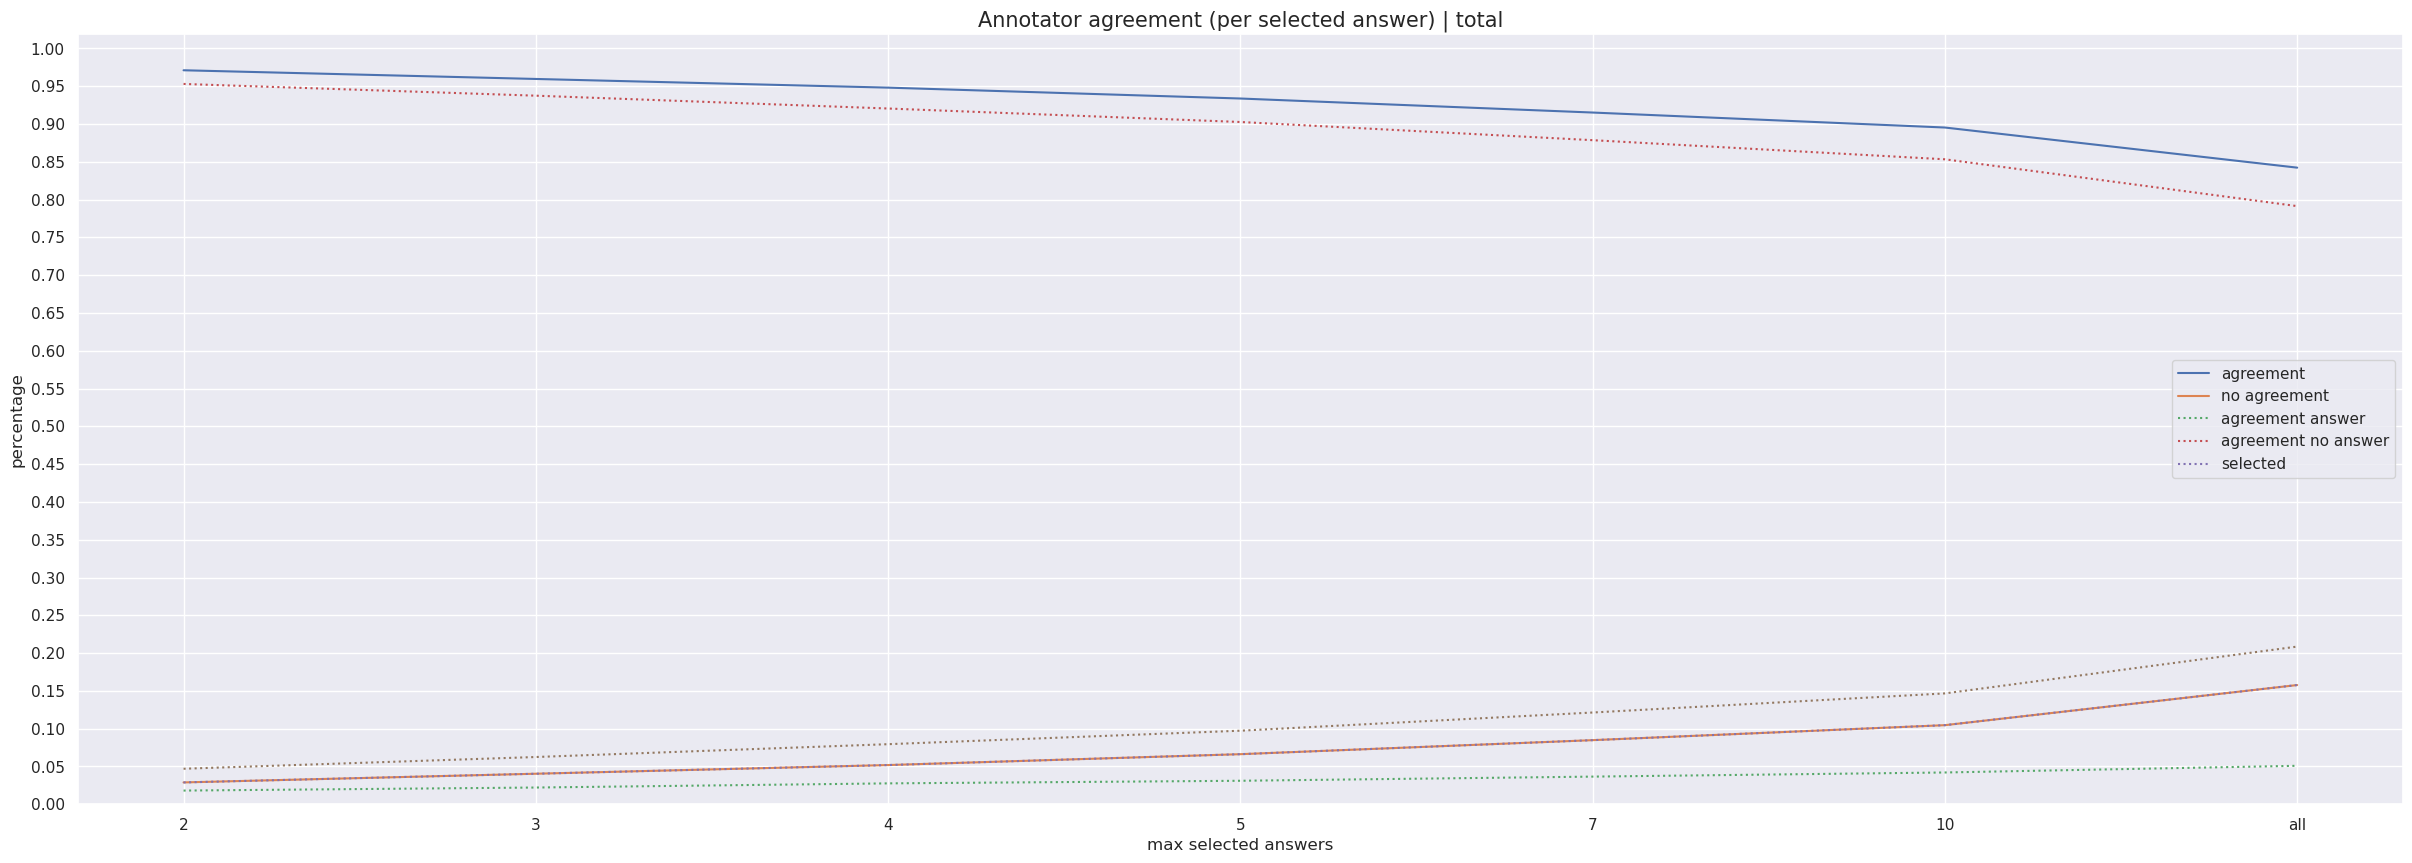

In [76]:
# Plot annotator agreement (per answer)
def get_annotator_agreement_per_answer(df, selected_only):
    raw_agreement_answer = 0
    raw_agreement_no_answer = 0
    raw_no_agreement = 0
    total = 0
    total_selected = 0
    
    for _, row in df.iterrows():
        possible_answers = len(row.context.split('\n'))
        total += possible_answers - 1
        for i in range(1, possible_answers):
            if i in row.answers0 and i in row.answers1:
                raw_agreement_answer += 1
            elif i not in row.answers0 and i not in row.answers1:
                raw_agreement_no_answer += 1
            else:
                raw_no_agreement += 1
                
            if i in row.answers0 or i in row.answers1:
                total_selected += 1
                
    if selected_only:
        agreement_answer = raw_agreement_answer / total_selected
        no_agreement = raw_no_agreement / total_selected
        return [agreement_answer, no_agreement]

    agreement = (raw_agreement_answer + raw_agreement_no_answer) / total
    no_agreement = raw_no_agreement / total
    agreement_answer = raw_agreement_answer / total
    agreement_no_answer = raw_agreement_no_answer / total
    return [agreement, no_agreement, agreement_answer, agreement_no_answer, no_agreement, total_selected / total]

def get_max_answers_agreement_per_answer(df, selected_only):
    agreements = []
    for max_answers in max_answers_thresholds:
        agreements.append(get_annotator_agreement_per_answer(get_double_annotations_max_answers(df, max_answers), selected_only))
    agreements.append(get_annotator_agreement_per_answer(df, selected_only))

    return pd.DataFrame(agreements)


selected_only_params = [True, False]
for selected_only in selected_only_params: 
    max_answers_agreement_per_answer_df = get_max_answers_agreement_per_answer(double_annotations_df, selected_only)

    labels_x = [f'{max_answers}' for max_answers in max_answers_thresholds]
    labels_x.append('all')

    _,ax = plt.subplots(figsize=(30, 10))
    ax.set_xlabel('max selected answers')
    ax.set_ylabel('percentage')

    for index in range(len(max_answers_agreement_per_answer_df.columns)):
        max_answers_agreement_per_answer_df.iloc[:, index].plot.line(ax=ax, linestyle='-' if index < 2 else ':')

    if selected_only:
        ax.set_title('Annotator agreement (per selected answer) | selected only', fontsize=15)
        ax.legend(['agreement', 'no agreement'])
        ax.set_yticks(numpy.arange(0, 0.90, 0.05))
    else:
        ax.set_title('Annotator agreement (per selected answer) | total', fontsize=15)
        ax.legend(['agreement', 'no agreement', 'agreement answer', 'agreement no answer', 'selected'])
        ax.set_yticks(numpy.arange(0, 1.05, 0.05))
    ax.set_xticks(numpy.arange(0, len(max_answers_thresholds) + 1, 1))
    ax.set_xticklabels(labels_x)
    ax.set_ylim(0)
    plt.show()


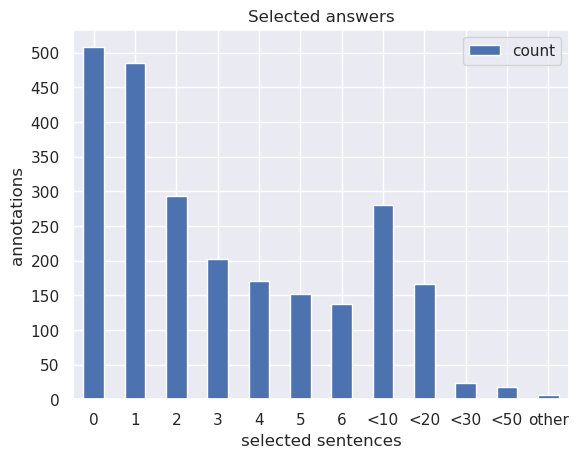

Average selected answers per annotation: 4.16
Median selected answers per annotation: 2.0


In [25]:
# Plot selection count
annotations_df.value_counts(annotations_df.selected).reset_index()
annotations_count_bins = pd.cut(annotations_df['selected'], bins=numpy.array([-1, 0, 1, 2, 3, 4, 5, 6, 10, 20, 30, 50, 1000])).value_counts().reset_index()
annotations_count_bins.columns = ['bin', 'count']
annotations_count_bins['sort'] = annotations_count_bins.bin.map(lambda x: x.left)
annotations_count_bins = annotations_count_bins.sort_values('sort')

ax = annotations_count_bins.plot.bar(rot=0, color='b')
ax.set_title('Selected answers')
labels = [round(bin.right) if bin.right < 10 else f'<{round(bin.right)}' for bin in annotations_count_bins['bin'][:-1]]
labels.append('other')
ax.set_xticklabels(labels)
ax.set_yticks(numpy.arange(0, 550, 50))
plt.xlabel('selected sentences')
plt.ylabel('annotations')
plt.show()

print(f'Average selected answers per annotation: {round(annotations_df.selected.mean(), 2)}')
print(f'Median selected answers per annotation: {int(annotations_df.selected.median())}')

# Plot char/sentences count
annotations_df.value_counts(annotations_df.selected).reset_index()
annotations_count_bins = pd.cut(annotations_df['selected'], bins=numpy.array([-1, 0, 1, 2, 3, 4, 5, 6, 10, 20, 30, 50, 1000])).value_counts().reset_index()
annotations_count_bins.columns = ['bin', 'count']
annotations_count_bins['sort'] = annotations_count_bins.bin.map(lambda x: x.left)
annotations_count_bins = annotations_count_bins.sort_values('sort')

ax = annotations_count_bins.plot.bar(rot=0, color='b')
ax.set_title('Selected answers')
labels = [round(bin.right) if bin.right < 10 else f'<{round(bin.right)}' for bin in annotations_count_bins['bin'][:-1]]
labels.append('other')
ax.set_xticklabels(labels)
ax.set_yticks(numpy.arange(0, 550, 50))
plt.xlabel('selected sentences')
plt.ylabel('annotations')
plt.show()

print(f'Average selected answers per annotation: {round(annotations_df.selected.mean(), 2)}')
print(f'Median selected answers per annotation: {int(annotations_df.selected.median())}')

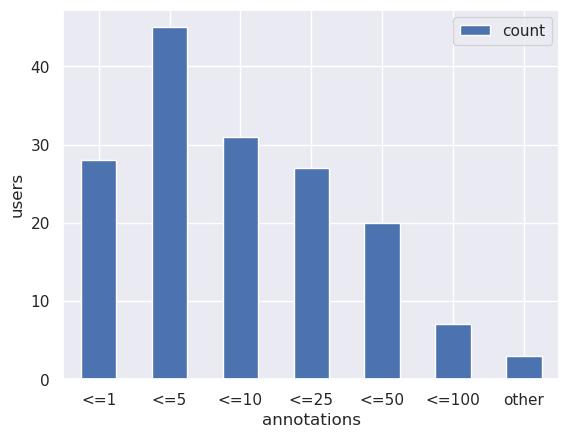

Average annotations per user: 15.16
Median annotations per user: 6.0


In [24]:
# Plot user contributions
group_by_user = annotations_df.user.value_counts().reset_index()
group_by_user.columns = ['user', 'annotations']
user_count_bins = pd.cut(group_by_user['annotations'], bins=numpy.array([0, 1, 5, 10, 25, 50, 100, 1000]), include_lowest=True).value_counts().reset_index()
user_count_bins.columns = ['bin', 'count']
user_count_bins['sort'] = user_count_bins.bin.map(lambda x: x.left)
user_count_bins = user_count_bins.sort_values('sort')

ax = user_count_bins.plot.bar(rot=0, color='b')
labels = [f'<={round(bin.right)}' if bin.right != 1000 else 'other' for bin in user_count_bins['bin']]
ax.set_xticklabels(labels)
plt.xlabel('annotations')
plt.ylabel('users')
plt.show()

print(f'Average annotations per user: {round(group_by_user.annotations.mean(), 2)}')
print(f'Median annotations per user: {int(group_by_user.annotations.median())}')